# Azure OpenAI Assistant API Mutli-Agent Example

## Setups

REQUIREMENTS:

Assistant models - Latest 1106 models

GPT4 Vision Model - vision-preview

Dall-e 3 Model - dall-e-3 3.0

#Install the required packages using pip. 

In [235]:
# %pip install -r requirements.txt

## Imports and environment variables

It's best practice to keep your secrets and keys in an environment variable file. You can do this by editing the "sample.env" file and renaming it to ".env".

In [236]:
import io
import os
import time
from datetime import datetime
from typing import Iterable
from matplotlib import pyplot as plt  
import cv2
import base64
from typing import List 
import requests  
from io import BytesIO  
from PIL import Image  
from pathlib import Path  

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile

load_dotenv()

api_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_key = os.getenv("AZURE_OPENAI_KEY")
api_version = os.getenv("AZURE_OPENAI_API_VERSION")

# name of the AOAI model deployment that is compatible with the Assistants API you want to use
api_deployment_name = os.getenv("GPT4_DEPLOYMENT_NAME")

# name of the model deployment for GPT 4 with Vision
api_deployment_name_vision = os.getenv("GPT4_VISION_DEPLOYMENT_NAME")

# name of the model deployment for DALL·E 3
api_deployment_name_dalle = os.getenv("DALLE3_DEPLOYMENT_NAME")

client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

## Image Generator Assistant

This agent is responsible for generating images using a prompt to the Dalle-3 Model. The output is a .jpg file stored in the users local directory.


#Image generator agent definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent
- Function = functions the agents has access to

In [237]:
name_dl = "dalle_assistant"
instructions_dl = """As a top-tier image generator AI, you are adept at creating accurate imaged from a prompt. You will properly create an image from the prompt. Ensure to execute the necessary image generation before responding to the user."""

tools = [
    {
        "type": "function",
        "function": {
            "name": "generate_image",
            "description": "Creates and displays an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {
                        "type": "string",
                        "description": "The prompt to be used to create the image",
                    }
                },
                "required": ["prompt"],
            },
        },
    }
]

verbose_output = True


## Agent Initialization

Initializes the agent with the definition described above

In [238]:

dalle_assistant = client.beta.assistants.create(
  name=name_dl,
  instructions=instructions_dl,
  model=api_deployment_name,
  tools=tools
)

GPT4Assistant


## Image Generator "generate_image" function

This function calls the Dalle-3 image generator given the prompt

In [239]:
def generate_image(prompt: str) -> str:  
    """  
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.  
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.  
  
    @param prompt_str: The prompt to be used to generate the image  
    @return: returns the file path of the file  
    """  
    response = client.images.generate(  
        model="Dalle3",  
        prompt=prompt,  
        size="1024x1024",  
        quality="standard",  
        n=1  
    )  
  
    # Retrieve the image URL from the response (assuming response structure)  
    image_url = response.data[0].url  
  
    # Open the image from the URL and save it to a temporary file.  
    im = Image.open(requests.get(image_url, stream=True).raw)  
  
    # Define the filename and path where the image should be saved.  
    filename = "temp.jpg"  
    local_path = Path(filename)  
  
    # Save the image.  
    im.save(local_path)  
  
    # Get the absolute path of the saved image.  
    full_path = str(local_path.absolute())  
    
    img = cv2.imread('temp.jpg', cv2.IMREAD_UNCHANGED)  
    
    # Convert the image from BGR to RGB for displaying with matplotlib,  
    # because OpenCV uses BGR by default and matplotlib expects RGB.  
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    
    # Display the image with matplotlib.  
    plt.imshow(img_rgb)  
    plt.axis('off')  # Turn off axis labels.  
    plt.show()  

    # Return the full path of the saved image.  
    print("Dalle Assistant Message: " + full_path)
    return full_path  


# Vision Assistant

This agent is responsible for analyzing images. The output is a new prompt to be used by the image creator agent.


#Vision assistant definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent
- Function = functions the agents has access to

In [240]:
name_vs = "vision_assistant"
instructions_vs = """As a top-tier image analyzer AI, you are adept at analyzing and criticizing images to enhance them. You will properly analyze an image. Ensure to execute the necessary image analyzes are performed before responding to the user."""

tools = [
    {
        "type": "function",
        "function": {
            "name": "analyze_image",
            "description": "analyzes and critics an image",
            "parameters": {
                "type": "object",
                "properties": {
                    "image_filename": {
                        "type": "string",
                        "description": "The local image file name including the full path",
                    }
                },
                "required": ["image_filename"],
            },
        },
    }
]

verbose_output = True


## Agent Initialization

Initializes the agent with the definition described above

In [241]:
vision_assistant = client.beta.assistants.create(
    name=name_vs,
    instructions=instructions_vs,
    model=api_deployment_name,
    tools=tools
)

GPT4Assistant


## Vision Assistant "analyze_image" function

This function calls the GPT4 Vision image analyzes given an image

In [242]:
def analyze_image(image_filename: str) -> str:
    """
    Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis

    @param prompt_str: The prompt to be used to analyze the image
    @return: returns the analyzes of the image into a prompt for dalle-3

    """
    import base64
    base64_image = base64.b64encode(open("temp.jpg", "rb").read()).decode("utf-8")

    content_images = [{"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}} for base64_image in [base64_image]]
    response = client.chat.completions.create(
    model="GPT4Vision",
    messages=[
        {
        "role": "user",
                "content": [
                {"type": "text", "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis."}
            ] + content_images,
        }
    ],
    max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    return response.choices[0].message.content

## User Proxy

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


### Proxy Assistant definition.

- Assistant name = the name of the agent
- Assistant instructions = description of the agent including agents this user proxy has access to.
- Function = functions the agents has access to. send_message sends messages to the other agents and agent_name specifies which agent to communicate with

In [243]:

name_pa = "user_proxy"
agent_arr = ["dalle_assistant","vision_assistant"]
agent_string = ""
for item in agent_arr: 
    agent_string += f"{item}\n"
    
instructions_pa = f"""Your role as a user proxy agent is to facilitate communication between the user and the specialized agents in this group chat. You are required to convey user inquiries clearly to the appropriate agents and ensure consistent interaction to ensure the user's request is fully executed. Refrain from replying to the user until the task is finalized, an issue is identified by the corresponding agent, or when your reply is definitive.

You have access to the following agents to accomplish the task:
{agent_string}
If the agents above are not enough or are out of scope to complete the task, then run send_message with the name of the agent.

When outputting the agent names, use them as the basis of the agent_name in the send message function, even if the agent doesn't exist yet.

Run the send_message function for each agent name generated. 

Do not ask for followup questions, run the send_message function according to your initial input.
"""

tools = [
    {
        "type": "function",
        "function": {
            "name": "send_message",
            "description": "Send messages to other agents in this group chat.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The message to be sent",
                    },
                    "agent_name": {
                        "type": "string",
                        "description": "The name of the agent to execute the task.",
                    }
                },
                "required": ["query","agent_name"],
            },
        },
    }
]

verbose_output = True


## Agent Initialization

Initializes the agent with the definition described above

In [244]:
user_proxy = client.beta.assistants.create(
  name=name_pa,
  instructions=instructions_pa,
  model=api_deployment_name,
  tools=tools
)

GPT4Assistant


### Proxy Assistant "send_message" function

This function calls the Assistant API to generate a main thread of communication between the agents listed in the agents_threads 

In [245]:
from typing import Dict, Optional  

agents_threads: Dict[str, Dict[str, Optional[str]]] = {  
    "dalle_assistant": {  
        "agent": dalle_assistant, 
        "thread": None
    },
    "vision_assistant": {  
        "agent": vision_assistant, 
        "thread": None
    } 
}  

# Define the send_message function with only the query parameter  
def send_message(query: str, agent_name: str) -> str:  
    # Check if the agent_name is in agents_threads  
    if agent_name not in agent_arr:  
        print(f"Agent '{agent_name}' does not exist. *** AGENT SWARM***")  
        #return None  
    # If the program has not exited, proceed with setting the agent recipient  
    recipient_type = agent_name  
    recipient_info = agents_threads[recipient_type]

    # If the program has not exited, proceed with setting the agent recipient  
    recipient_type = agent_name  
    recipient_info = agents_threads[recipient_type] 
    
    #Create a new thread if user proxy and agent thread does not exist
    if not recipient_info["thread"]:  
        thread_object = client.beta.threads.create()  
        recipient_info["thread"] = thread_object  

    # This function dispatches a message to the proper agent and it's thread
    message = dispatch_message(query, recipient_info["agent"], recipient_info["thread"])  
    #print("Proxy Assistant Message: " + message)
    return message  


## The main multi-agent communication flow

This agent facilitates the conversation between the user and other agents, ensuring successful completion of the task.


In [246]:
import time
import json

def dispatch_message(message, agent, thread):
  

    #Loops through all the agents functions to determine which function to use
    
    available_functions = {}  
      
    # Iterate through each tool in the agent.tools list  
    for tool in agent.tools:  
        # Check if the tool has a 'function' attribute  
        if hasattr(tool, 'function'):  
            function_name = tool.function.name  
            # Attempt to retrieve the function by its name and add it to the available_functions dictionary  
            if function_name in globals():  
                available_functions[function_name] = globals()[function_name]  
        else:  
            # Handle the case where the tool does not have a 'function' attribute  
            print("This tool does not have a 'function' attribute.")  
  
    # create new message in the thread
    message = client.beta.threads.messages.create(
        thread_id=thread.id,
        role="user",
        content=message
    )
    # run this thread 
    run = client.beta.threads.runs.create(
      thread_id=thread.id,
      assistant_id=agent.id,
    )
    
    while True:
      # wait until run completes
      while run.status in ['queued', 'in_progress']:
        run = client.beta.threads.runs.retrieve(
          thread_id=thread.id,
          run_id=run.id
        )
        time.sleep(1)

      # Execute the proper function to execute the task if an action is required
      if run.status == "requires_action":
        tool_calls = run.required_action.submit_tool_outputs.tool_calls
        tool_outputs = []
        for tool_call in tool_calls:
          tool_responses = []
          if (
              run.required_action.type == "submit_tool_outputs"
              and run.required_action.submit_tool_outputs.tool_calls is not None
          ):
              tool_calls = run.required_action.submit_tool_outputs.tool_calls

              for call in tool_calls:
                        if call.type == "function":
                            if call.function.name not in available_functions:
                                raise Exception("Function requested by the model does not exist")
                            
                            #associate the proper function to the agent to call
                            function_to_call = available_functions[call.function.name]
                            tool_response = function_to_call(**json.loads(call.function.arguments))
                            tool_responses.append({"tool_call_id": call.id, "output": tool_response})
                            
                            
        # submit tool outputs
        run = client.beta.threads.runs.submit_tool_outputs(
            thread_id=thread.id,
            run_id=run.id,
            tool_outputs=tool_responses
        )
        
      # error
      elif run.status == "failed":
        raise Exception("Run Failed. Error: ", run.last_error)
      # return assistant message
      else:
        messages = client.beta.threads.messages.list(
          thread_id=thread.id
        )
        
        #Output the reply message back to the proxy agent
        message = messages.data[0].content[0].text.value
        return message

# Example Questions:


1.   Generate an image of a boat drifting in the water and analyze it and enhance the image
2.   Generate an image of a space civilization, analyze it and enhance it. Do this several times until image satisfies request

Note: the assistants are configured to work together to complete the task. The user proxy agent is responsible for sending messages to the other agents and ensuring the task is completed successfully. It may take several iterations and several minutes to complete the task. 


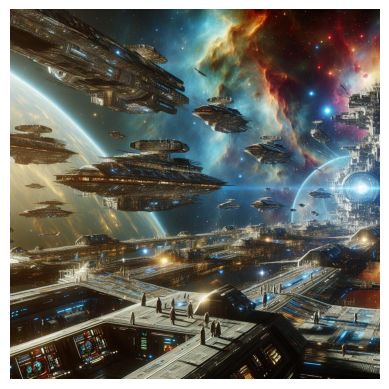

Dalle Assistant Message: c:\Users\simonlacasse\Downloads\temp.jpg
Vision Assistant Message: Analysis:
The image depicts a bustling spaceport with a multitude of spacecraft and a vibrant nebula in the background. The level of detail in the spacecraft's design and the lighting on the spaceport is impressive. The use of light and shadow creates a sense of depth and movement, while the color palette provides a sense of scale and wonder. The nebula adds a surreal and otherworldly feel.

Criticism:
While the image is visually stunning, there is a lack of clear focal point which may leave the viewer's eye wandering. The spaceport itself could use some more diversity in the design of the structures to avoid repetition. The nebula, while beautiful, may be too overpowering and take away from the intricacies of the spacecraft and spaceport.

Enhanced Prompt for Dall-e:
Create an image of a spaceport with a diverse range of spacecraft designs and more varied structures on the spaceport. Include a 

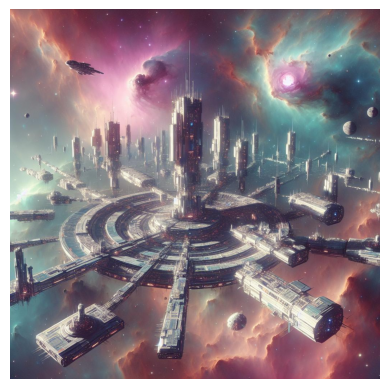

Dalle Assistant Message: c:\Users\simonlacasse\Downloads\temp.jpg
Vision Assistant Message: This image portrays a futuristic city amidst a vibrant and colorful nebula in space. The city's architecture is a fusion of sleek, modern skyscrapers and massive circular platforms, suggesting advanced technology and efficient urban planning. There are several spacecrafts around the city, indicating a well-connected and possibly intergalactic civilization.

The image is visually striking with its contrasting colors and use of light to create a sense of depth and dimensionality. The central tower, which stands out due to its height and brightness, appears to be the focal point of the city, and possibly a hub of power or governance.

One criticism of the image could be the lack of a clear indication of life or activity within the city. While the infrastructure is impressive, there are no visible signs of inhabitants or movement, which can make the city feel sterile or abandoned.

Another criticism

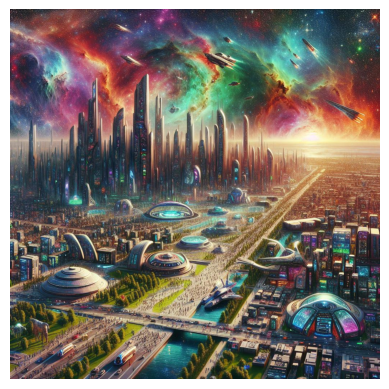

Dalle Assistant Message: c:\Users\simonlacasse\Downloads\temp.jpg


In [247]:
thread = client.beta.threads.create()

#Initiate proxy agent and the main thread. This thread will remain active until the task is completed and will serve as the main communication thread between the other agents.
user_message = input("User Query: ")
message = dispatch_message(user_message, user_proxy, thread)